In [29]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
import matplotlib.pyplot as plt
import datetime

# Loading data

In [60]:
weather_a = pd.read_csv('data/2149507.csv')
mobility = pd.read_csv('data/Global_Mobility_Report.csv', dtype = {'sub_region_1': str, 'sub_region_2': str})
china_mobility = pd.read_csv('data/China_(City Movement Intensity) 0101-0502.csv')
us_cases = pd.read_csv('data/US_covid_by_county.csv')
china_cases = pd.read_csv('data/China_covid_by_city.csv') 
decentralization = pd.read_excel('data/Kopie+von+Ivanyna+Shah+Decentralization+Dataset+Jan+2014.xls', 'Data')
mobilityus = pd.read_csv('data/mobilityus.csv')
covid_stringency = pd.read_csv('data/covid-stringency-index.csv')
county_pres = pd.read_csv('data/countypres_2000-2016.csv')
china_data_raw = pd.read_csv('data/chnmobility.csv')

##  United States: Centralized Dataframe

In [242]:
data = mobilityus.dropna().copy()
data.date = pd.to_datetime(data.date)
data['avg_mobility'] = data.filter(['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']).mean(axis = 1)

# adding interaction terms
data['demxSAH'] = data['dem_share'] * data['stay_at_home']
data['demxcases'] = data['dem_share'] * data['covid_cases']
data['popxpct_pov'] = data['pop'] * data['pct_pov']
data['SAHxpop'] = data['pop'] * data['stay_at_home']

data[data.state== 'Washington'].county.unique()

array(['Benton County', 'Chelan County', 'Clallam County', 'Clark County',
       'Cowlitz County', 'Franklin County', 'Grant County',
       'Grays Harbor County', 'Island County', 'King County',
       'Kitsap County', 'Kittitas County', 'Lewis County',
       'Pierce County', 'Skagit County', 'Snohomish County',
       'Spokane County', 'Thurston County', 'Walla Walla County',
       'Whatcom County', 'Yakima County'], dtype=object)

## Plots
5 counties for average mobility across all sectors

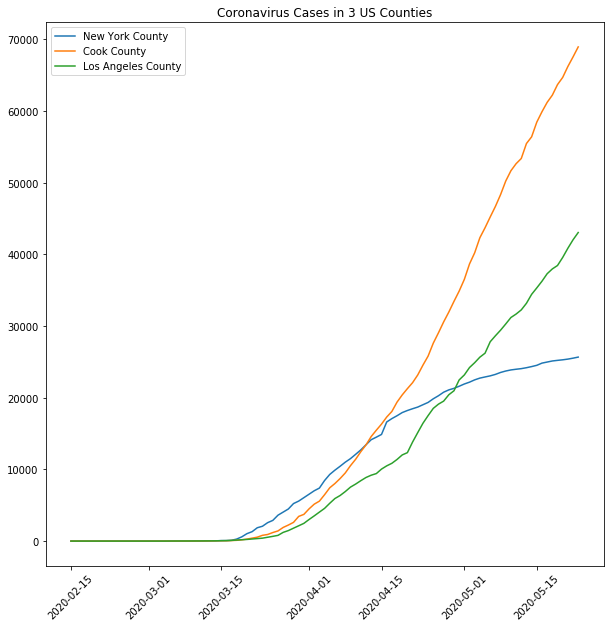

In [247]:
plt.figure(figsize = (10, 10))
for county in ['New York County', 'Cook County', 'Los Angeles County']:
    plt.plot(data[data.county == county].date, data[data.county == county].covid_cases, label = county)
plt.xticks(rotation = 45)
plt.legend()
plt.title('Coronavirus Cases in 3 US Counties')
plt.show()

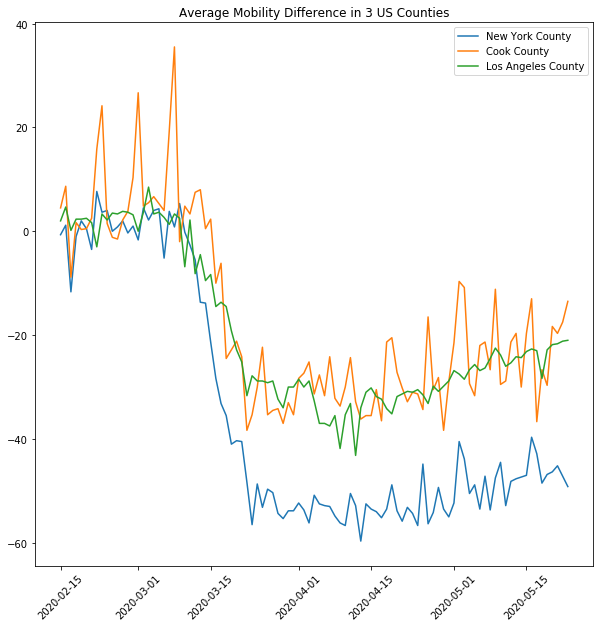

In [244]:
plt.figure(figsize = (10, 10))
for county in ['New York County', 'Cook County', 'Los Angeles County']:
    plt.plot(data[data.county == county].date, data[data.county == county].avg_mobility, label = county)
plt.xticks(rotation = 45)
plt.legend()
plt.title('Average Mobility Difference in 3 US Counties')
plt.show()

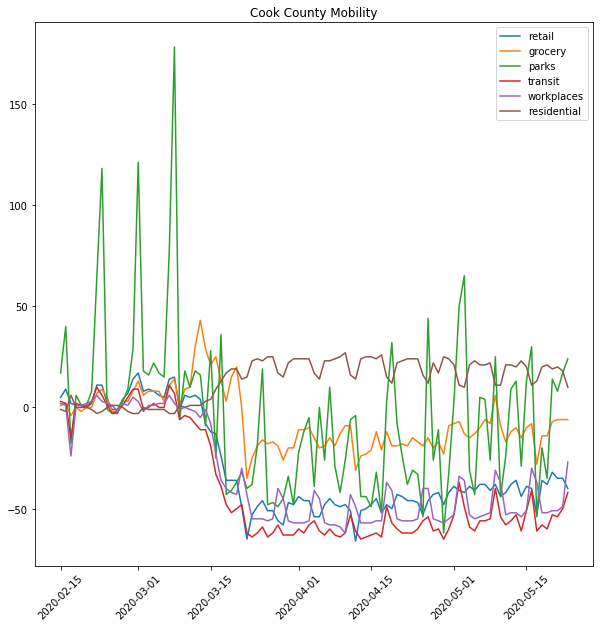

In [6]:
plt.figure(figsize = (10, 10))
state = data[data.state == 'Illinois']
for column in ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']:
    plt.plot(state[state.county == 'Cook County'].date, state[state.county == 'Cook County'][column], label = column)
plt.xticks(rotation = 45)
plt.title('Cook County Mobility')
plt.legend()
plt.show()

## China Mobility Dataframe
#### compute baseline: the median value, for the corresponding day of the week, from Jan 1 - Jan-15


In [185]:
china = china_mobility.T.copy()
china.columns = china.iloc[0]
china = china[1:]
china.index = pd.to_datetime(china.index)
china = china.astype('float')
china = china.reset_index()
# find day of the week
china['weekday'] = china['index'].dt.dayofweek
temp = china[(china['index'] >= '2020-01-01') & (china['index'] <= '2020-01-15')]

baseline = temp.iloc[:, 1:].groupby('weekday').median()

# compute the percentage differences from the baseline
def compute_diff(row, baseline):
    day = row['weekday']
    return (row[1:-1] - baseline.loc[day, :]) * 100

modified_china = china.apply(lambda row: compute_diff(row, baseline), axis = 1)

modified_china['date'] = china['index']

In [199]:
# changing city names
city_names = []
for name in modified_china.columns[:-1]:
    city_names.append(name.split('shi_', 1)[0])
for i in china_data.City.unique():
    if i not in city_names:
        print(i)
baseline.columns = city_names
baseline

,Beijing,Tianjin,Shijiazhuang,Tangshan,Qinhuangdao,Handan,Xingtai,Baoding,Zhangjiakou,Chengde,...,Kashidiqu_653100,Hetiandiqu_653200,Yilihasakezizhizhou_654000,Tachengdiqu_654200,Aleitaidiqu_654300,Shihezi,Alaer,Tumushuke,Wujiaqu,Tiemenguan
weekday,,,,,,,,,,,,,,,,,,,,,
0,6.39020,6.02305,5.50990,5.61520,5.36940,5.19520,4.91420,4.81560,4.80190,4.79325,...,5.79535,4.75840,4.66105,3.69495,3.47010,4.41800,3.86940,4.93400,3.22600,2.46425
1,6.42215,6.05810,5.70050,5.70775,5.50995,5.02605,4.83695,4.99225,4.95570,4.99075,...,5.51170,4.69075,4.58735,3.61315,3.42515,4.37600,3.70355,4.77665,3.16535,2.16795
2,6.37160,5.92800,5.76810,5.74870,5.53580,5.00250,4.90880,5.09970,4.95800,5.09620,...,5.62120,4.70770,4.62450,3.65500,3.44260,4.20930,3.86820,4.84880,3.20380,1.89110
3,6.53360,6.25470,5.82820,5.78705,5.65980,5.23110,5.09290,5.10605,5.06235,5.05170,...,5.75705,4.82040,4.66315,3.64995,3.44115,4.49570,4.08890,4.84100,3.27885,2.14925
4,6.62560,6.32105,5.92250,5.84080,5.72520,5.38970,5.23660,5.18480,5.19325,5.10560,...,5.80675,4.89535,4.69935,3.71790,3.51535,4.49670,3.94850,4.92175,3.27395,2.26540
5,4.92890,5.31215,5.31565,5.32365,5.11075,5.11145,5.00885,4.88105,4.77010,4.67560,...,5.68790,4.79850,4.44835,3.48970,3.29000,4.06050,3.56615,4.54365,3.05175,1.84395
6,4.65010,5.03415,4.82430,5.21970,4.92100,4.71215,4.62310,4.66640,4.62720,4.55605,...,5.51580,4.72050,4.38640,3.44930,3.25715,3.90485,3.52545,4.41980,2.95950,1.74845


## Centralized China Policy, Cases, and Mobility Dataframe

In [217]:
china_data = china_data_raw.drop('Unnamed: 0', axis = 1)
china_data['Date'] = pd.to_datetime(china_data['Date'])
china_data['Start.Date']= pd.to_datetime(china_data['Start.Date'])
china_data['weekday'] = china_data['Date'].dt.dayofweek
# compute the percentage differences from the baseline, for this new dataframe
def compute_diff_2(row, baseline):
    day = row['weekday']
    city = row['City']
    if city in ['Fuzhou', 'Suzhou', 'Taizhou']:
        return row['CMI'] - baseline.loc[day, city][0]
    return (row['CMI'] - baseline.loc[day, city]) * 1.0

china_data['mobility'] = pd.to_numeric(china_data.apply(lambda row: compute_diff_2(row, baseline), axis = 1, raw = True))
china_data['stay_at_home'] = (china_data.Date.values >= china_data['Start.Date'].values)
china_data['stay_at_home'] = china_data['stay_at_home'].replace({True: 1, False:0})

In [222]:
china_data['SAHxA'] = china_data['Policy.A..Complete.Shutdown.'] * china_data['stay_at_home']
china_data['SAHxB'] = china_data['Policy.B..Partial.Shutdowns.'] * china_data['stay_at_home']
china_data['SAHxC'] = china_data['Policy.C..Checkpoints.and.Quarantine.Zones.'] * china_data['stay_at_home']
china_data['SAHxConfCount'] = china_data['stay_at_home'] * china_data['ConfCount']
china_data

,City,Date,CMI,Province,Start.Date,Policy.A..Complete.Shutdown.,Policy.B..Partial.Shutdowns.,Policy.C..Checkpoints.and.Quarantine.Zones.,population,ConfCount,weekday,mobility,stay_at_home,SAHxA,SAHxB,SAHxC,SAHxConfCount
0,Beijing,2020-01-22,3.9546,Beijing,2020-02-10,0,0,1,11716620,10,2,-2.41700,0,0,0,0,0
1,Beijing,2020-01-23,3.0974,Beijing,2020-02-10,0,0,1,11716620,22,3,-3.43620,0,0,0,0,0
2,Beijing,2020-01-24,2.4029,Beijing,2020-02-10,0,0,1,11716620,36,4,-4.22270,0,0,0,0,0
3,Beijing,2020-01-25,1.8254,Beijing,2020-02-10,0,0,1,11716620,41,5,-3.10350,0,0,0,0,0
4,Beijing,2020-01-26,1.6544,Beijing,2020-02-10,0,0,1,11716620,68,6,-2.99570,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4845,Zhumadian,2020-03-28,4.5740,Henan,2020-02-04,0,1,0,720000,139,5,-0.63685,1,0,1,0,139
4846,Zhumadian,2020-03-29,3.7015,Henan,2020-02-04,0,1,0,720000,139,6,-1.26230,1,0,1,0,139
4847,Zhumadian,2020-04-06,4.7071,Henan,2020-02-04,0,1,0,720000,139,0,-0.64680,1,0,1,0,139
4848,Zhumadian,2020-04-12,4.7413,Henan,2020-02-04,0,1,0,720000,139,6,-0.22250,1,0,1,0,139


In [228]:
china_data.to_csv('data/china_combined_data.csv')

In [230]:
modified_china.columns

Index(['Beijingshi_110000', 'Tianjinshi_120000', 'Shijiazhuangshi_130100',
       'Tangshanshi_130200', 'Qinhuangdaoshi_130300', 'Handanshi_130400',
       'Xingtaishi_130500', 'Baodingshi_130600', 'Zhangjiakoushi_130700',
       'Chengdeshi_130800',
       ...
       'Hetiandiqu_653200', 'Yilihasakezizhizhou_654000', 'Tachengdiqu_654200',
       'Aleitaidiqu_654300', 'Shihezishi_659001', 'Alaershi_659002',
       'Tumushukeshi_659003', 'Wujiaqushi_659004', 'Tiemenguanshi_659006',
       'date'],
      dtype='object', name='GbCity_EN', length=363)

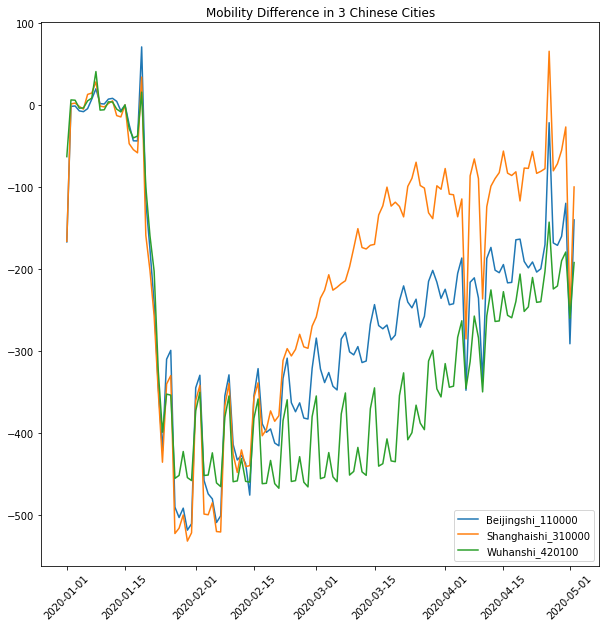

In [245]:
plt.figure(figsize = (10, 10))
for city in ['Beijing', 'Shanghai', 'Wuhan']:
    for shi in modified_china.columns:
        if city in shi:
            plt.plot(modified_china.date, modified_china[shi], label = shi)
plt.xticks(rotation = 45)
plt.title('Mobility Difference in 3 Chinese Cities')
plt.legend()
plt.show()

## Double LASSO - Feature Selection

Determine an adequate regularization parameter for both LASSOs


In [44]:
lambdas = np.logspace(-4, -1, 30)

In [215]:
def double_lasso(data, treatment, covariates, lambdas, us = True):
    '''
    Assumes treatment and covariates have already been standardized
    '''
    print('Treatment Variable: {} \nControl Variables: {}'.format(treatment, str(covariates)))
    print()
    X = data.filter([treatment] + covariates).values
    D = data.filter(covariates).values
    T = data[treatment].values
    responses = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential', 'avg_mobility'] if us else ['mobility']
    for response in responses:
        Y = data[response].values.astype('float')
        lasso1 = LassoCV(alphas = lambdas, normalize = True)
        lasso2 = LassoCV(alphas = lambdas, normalize = True)
        lasso1.fit(X, Y)
        lasso2.fit(D, T)
        print(response)
        beta_1 = lasso1.coef_
        beta_2 = lasso2.coef_
        print('LASSO 1 of Y on T and D: ' + str(beta_1))
        print('LASSO 2 of T on D: ' + str(beta_2))
        beta_1 = np.delete(beta_1, 0)
        print('Dropped Control Variables:')
        for i in range(len(beta_1)):
            if (beta_1[i] == 0) & (beta_2[i] == 0):
                print(covariates[i])
        print()

In [219]:
double_lasso(data, 'stay_at_home', 
             ['dem_share', 
              'income',
              'pop', 
              'pct_pov', 
              'covid_cases', 'demxSAH', 'demxcases', 'popxpct_pov','SAHxpop'],
            lambdas)

Treatment Variable: stay_at_home 
Control Variables: ['dem_share', 'income', 'pop', 'pct_pov', 'covid_cases', 'demxSAH', 'demxcases', 'popxpct_pov', 'SAHxpop']

retail
LASSO 1 of Y on T and D: [-9.96219988e+00 -0.00000000e+00 -1.03958924e-04 -0.00000000e+00
  1.13663818e-01 -7.26893749e-05 -4.47287584e+01 -0.00000000e+00
 -0.00000000e+00 -6.01988915e-08]
LASSO 2 of T on D: [-8.77095428e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.84634317e+00 -9.88820408e-07 -0.00000000e+00
 -0.00000000e+00]
Dropped Control Variables:
pop
popxpct_pov

grocery
LASSO 1 of Y on T and D: [-2.13431199e+00 -3.45407400e+00 -5.40698854e-05 -0.00000000e+00
  1.13901008e-01  0.00000000e+00 -2.58489496e+01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
LASSO 2 of T on D: [-8.77095428e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.84634317e+00 -9.88820408e-07 -0.00000000e+00
 -0.00000000e+00]
Dropped Control Variables:
pop
covid_cases
popxpct_pov
SAHxpop

park

### For China

In [224]:
double_lasso(china_data, 'stay_at_home', ['Policy.A..Complete.Shutdown.', 'Policy.B..Partial.Shutdowns.', 
                                         'Policy.C..Checkpoints.and.Quarantine.Zones.', 'population',
                                         'ConfCount', 'SAHxA', 'SAHxB', 'SAHxC', 'SAHxConfCount'], lambdas, us = False)



Treatment Variable: stay_at_home 
Control Variables: ['Policy.A..Complete.Shutdown.', 'Policy.B..Partial.Shutdowns.', 'Policy.C..Checkpoints.and.Quarantine.Zones.', 'population', 'ConfCount', 'SAHxA', 'SAHxB', 'SAHxC', 'SAHxConfCount']

mobility
LASSO 1 of Y on T and D: [ 1.34004272e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.28687843e-08 -2.12394934e-05 -1.25153369e-01  0.00000000e+00
  1.02115536e-01 -0.00000000e+00]
LASSO 2 of T on D: [ 0.          0.         -0.04945001 -0.          0.          0.87421297
  0.86475259  0.92819239  0.        ]
Dropped Control Variables:
Policy.A..Complete.Shutdown.
Policy.B..Partial.Shutdowns.
SAHxConfCount



### USA Double LASSO only with Dates after 3/15

In [227]:
double_lasso(data[data.date > '2020-03-15'], 'stay_at_home', 
             ['dem_share', 
              'income',
              'pop', 
              'pct_pov', 
              'covid_cases', 'demxSAH', 'demxcases', 'popxpct_pov','SAHxpop'],
            lambdas)

Treatment Variable: stay_at_home 
Control Variables: ['dem_share', 'income', 'pop', 'pct_pov', 'covid_cases', 'demxSAH', 'demxcases', 'popxpct_pov', 'SAHxpop']

retail
LASSO 1 of Y on T and D: [ 0.00000000e+00 -2.84480143e+01 -1.66962887e-04 -0.00000000e+00
  1.05999406e-01 -0.00000000e+00 -9.16571572e+00 -1.30682482e-04
 -0.00000000e+00 -7.27003246e-08]
LASSO 2 of T on D: [-1.35785812 -0.         -0.         -0.         -0.          1.82772381
 -0.         -0.         -0.        ]
Dropped Control Variables:
pop
covid_cases
popxpct_pov

grocery
LASSO 1 of Y on T and D: [-0.00000000e+00 -8.53417897e+00 -9.29898928e-05 -0.00000000e+00
  1.19070586e-01  0.00000000e+00 -1.81726297e+01  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]
LASSO 2 of T on D: [-1.35785812 -0.         -0.         -0.         -0.          1.82772381
 -0.         -0.         -0.        ]
Dropped Control Variables:
pop
covid_cases
demxcases
popxpct_pov
SAHxpop

parks
LASSO 1 of Y on T and D: [ 2.02435250e+01  2.20708